# Prediction Model
Using real web-scraped ROA, ROE, stock data and dummy ESG core metric scores  
Update to use our real ESG core metric scores please

## To Dos:
1) Feature importance and feature selection to determine which features (ESG metrics) are most important in determining ROA, ROE, stock growth
2) Correlation of ESG performance (ESG metrics / overall ESG rating) with profitability (ROA, ROE), stock price performance
3) Model needs to be trained and tested

Extra:
Automate by extracting directly from our SQL database

Note:
I think they refer to important features as 'Material ESG issues' - issues that are considered to be financially material to a given company in a relevant sub-industry.
https://www.sustainalytics.com/esg-rating/apple-inc/1007903183

## Import Libraries and Data
With data engineering and merging

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VARMAX
from datetime import datetime

In [3]:
# Load the data (replace with your file paths)
# esg_data = pd.read_csv("dummy_esg_ratings_10years.csv")
esg_data = pd.read_csv("esg_dataset_2019_2024.csv")
roa_roe = pd.read_csv("roa_roe_table_rows.csv")
stocks = pd.read_csv("stocks_table_rows.csv")

#esg_data["date"] = pd.to_datetime(esg_data["year"].astype(str) + "-12-31")
roa_roe["date"] = pd.to_datetime(roa_roe["date"])
roa_roe["year"] = roa_roe["date"].dt.year
stocks["date"] = pd.to_datetime(stocks["date"])
stocks["year"] = stocks["date"].dt.year
stocks["month"] = stocks["date"].dt.month

Transform stock value to stock percentage growth (annual linear return)

In [4]:
# Compute the first (Jan) and last (Dec) stock price for each company-year
prices_year_start = stocks[stocks['month'] == 1].set_index(['company', 'year'])[['close']].rename(columns={'close': 'beginning_price'}).sort_values(by=['company','year'])    
prices_year_end = stocks[stocks['month'] == 12].set_index(['company', 'year'])[['close']].rename(columns={'close': 'ending_price'}).sort_values(by=['company','year'])    

# Merge to get both beginning and ending stock prices
stocks_return = prices_year_start.join(prices_year_end).reset_index()

# Compute annual linear return
stocks_return['stock growth'] = (stocks_return['ending_price'] - stocks_return['beginning_price']) / stocks_return['beginning_price']

stocks_return

,company,year,beginning_price,ending_price,stock growth
0,3M,2016,92.046814,111.769226,0.214265
1,3M,2017,109.422089,150.780930,0.377975
2,3M,2018,160.473434,125.300278,-0.219184
3,3M,2019,131.718506,119.923889,-0.089544
4,3M,2020,107.851250,123.240036,0.142685
...,...,...,...,...,...
322,petrobras,2021,3.606838,4.318497,0.197308
323,petrobras,2022,5.901206,7.631315,0.293179
324,petrobras,2023,8.312044,14.437020,0.736880
325,petrobras,2024,15.431430,11.940595,-0.226216


In [5]:
# Merge the datasets on company and year
esg_roa_roe = pd.merge(esg_data, roa_roe, on=["company", "year"], how="inner")
esg_financial = pd.merge(esg_roa_roe, stocks_return, on=["company", "year"], how="inner")

# Drop rows (years) where ROA, ROE or stock growth values are missing
esg_financial = esg_financial.dropna(subset=['roa', 'roe', 'stock growth'])

#esg_financial.iloc[:, 2:-6]
esg_financial

,company,year,Greenhouse Gas Emission reduction,Energy Consumption reduction,Water consumption reduction,Waste reduction,Current Employees by Gender,Turnover rate by Gender,New Hires by Gender,Current Employees by Age Groups,...,Anti-Corruption Training for Employees,Certification,Alignment with frameworks and disclosure practices,Assurance of sustainability report,date,roa,roe,beginning_price,ending_price,stock growth
1,Apple,2021,5.237019,4.825104,4.502678,4.304374,6.370587,5.753542,6.420591,7.075706,...,6.022046,7.089833,7.844130,6.757972,2021-09-30,0.269742,1.500713,128.895996,174.516266,0.353931
2,Apple,2022,5.442395,5.007072,4.435172,4.231261,6.613789,5.761023,6.726037,6.932698,...,6.491220,7.407821,7.689429,6.670171,2022-09-30,0.282924,1.969589,171.774246,128.436676,-0.252294
3,Apple,2023,5.678213,5.413734,4.858803,4.299563,6.805548,5.879093,6.972539,7.248936,...,6.442672,7.352476,7.968504,7.014166,2023-09-30,0.275098,1.560760,142.631592,191.380966,0.341785
4,Apple,2024,5.840448,5.672793,5.119440,4.477553,6.858709,6.054819,7.142662,7.391516,...,6.328781,7.363810,8.137427,6.889458,2024-09-30,0.256825,1.645935,183.299484,250.144974,0.364679
5,Capgemini,2020,5.167925,4.668234,4.362359,4.202932,6.009854,5.635831,6.032952,6.801630,...,6.029113,7.193118,7.404774,6.662995,2020-12-31,0.043591,0.156808,22.949928,28.947523,0.261334
6,Capgemini,2021,5.574035,4.739254,4.232433,4.062940,6.283334,5.504289,6.599305,7.076552,...,6.333859,7.215648,7.793502,6.546149,2021-12-31,0.048142,0.136648,27.172928,46.544224,0.712890
7,Capgemini,2022,5.536341,5.034236,4.697459,4.336225,6.487419,5.697168,6.491133,7.161305,...,6.448071,7.157976,7.844947,6.828490,2022-12-31,0.060717,0.159042,42.483250,32.118401,-0.243975
8,Capgemini,2023,5.626448,5.169103,4.978446,4.580197,6.844577,5.889806,6.732883,7.162830,...,6.273081,7.442856,7.897883,6.756033,2023-12-31,0.067328,0.159078,36.453518,41.177574,0.129591
10,DataDog,2021,5.258818,4.935020,4.286101,4.043618,6.437723,5.567853,6.440116,6.872696,...,6.027921,7.258569,7.653964,6.846295,2021-12-31,-0.008713,-0.019924,102.750000,178.110001,0.733431
11,DataDog,2022,5.417936,5.138610,4.423064,4.142715,6.526165,5.737480,6.598143,7.146673,...,6.264371,7.330797,7.772714,6.740059,2022-12-31,-0.016693,-0.035562,146.110001,73.500000,-0.496954


## Long Term Trends in ESG Performance
Done according to the Playbook but what on earth is this meant to show

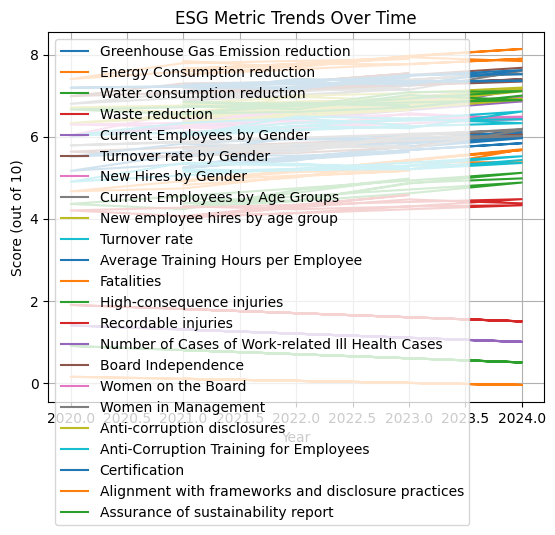

In [66]:
esg_metrics = esg_data.drop(columns=["company", "year"])

for metric in esg_metrics:
    plt.plot(esg_financial['year'], esg_financial[metric], label=metric)

# Customize the plot
plt.title('ESG Metric Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Score (out of 10)')
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.show()

## ESG-Finance Correlation
How ESG core metrics correlate with financial indicators (ROA, ROE, stock growth)

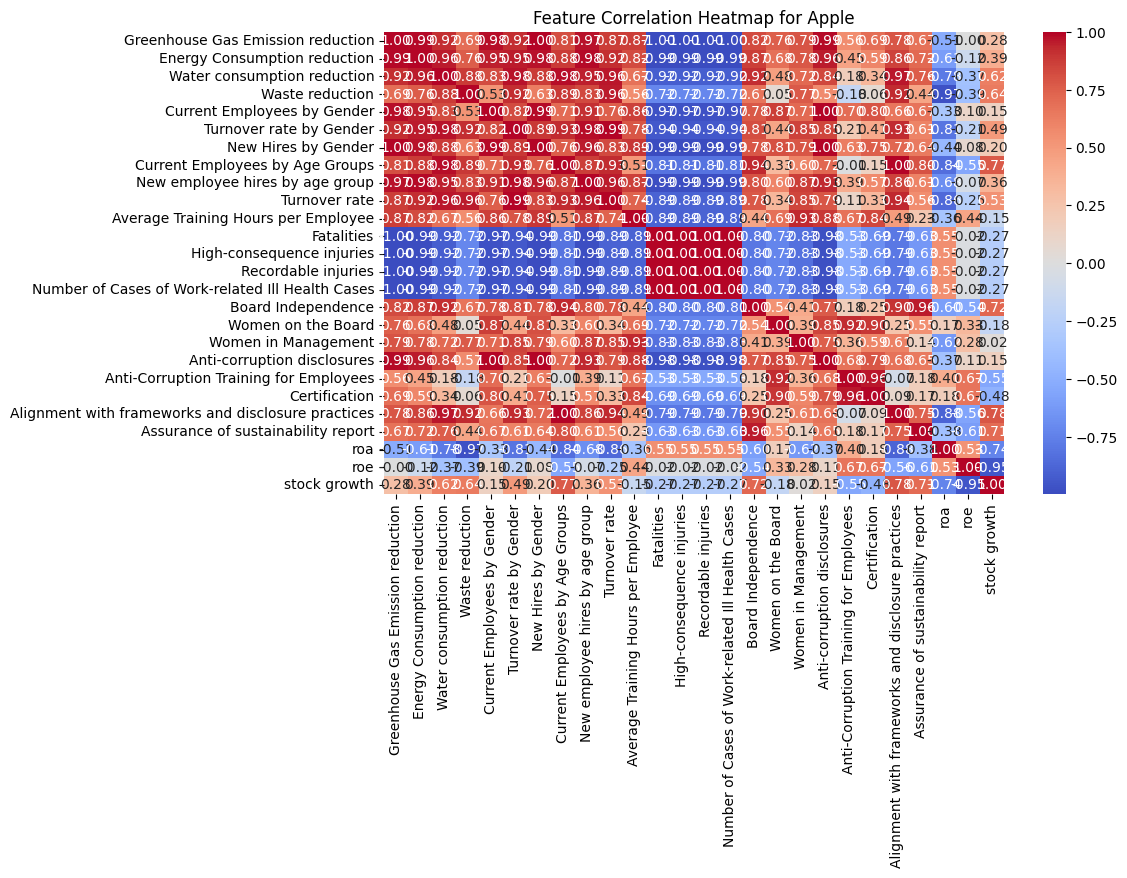

In [52]:
# Compute correlation for each company separately
correlation_results = {}

for company, data in esg_financial.groupby('company'):
    correlation_matrix = data.drop(columns=['company', 'year', 'date', 'beginning_price', 'ending_price']).corr()
    correlation_results[company] = correlation_matrix

# Example: Access correlation matrix for company 'Apple'
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_results['Apple'], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap for Apple")
plt.show()

## Feature Importance
Determine which features (ESG metrics) are most important in determining ROA, ROE, stock prices  
Within each industry

x = esg_data.columns  
y = ROA, ROE, stock growth

### Try Random Forest
Warning: works with non-linear relationships so the most important features that they identify may not be accurate for my linear regression model   

Issues:
- This doesn't really make sense anymore cuz I'm using the ESG core metrics as the X features but not the year   
->> But its supposed to be a time series???
- I would get the feature importance for ROA, ROE and Stock Growth separately, then how do I determine the top 5 ???

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [56]:
esg_financial["company"].unique()

array(['Apple', 'Capgemini', 'DataDog', 'WiseTech Global'], dtype=object)

In [58]:
# Load dataset
# Experiment with just Apple
df = esg_financial[esg_financial["company"] == "Apple"]

# Define dependent variables (targets) and independent variables (features)
y = df[['roa', 'roe', 'stock growth']]  # Targets
X = df.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'date', 'beginning_price', 'ending_price'])  # Features (ESG metrics)

In [59]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
feature_importance = {}

for target in y.columns:
    # Train Random Forest for each dependent variable
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train[target])

    # Get feature importance
    importance = rf.feature_importances_
    feature_importance[target] = importance

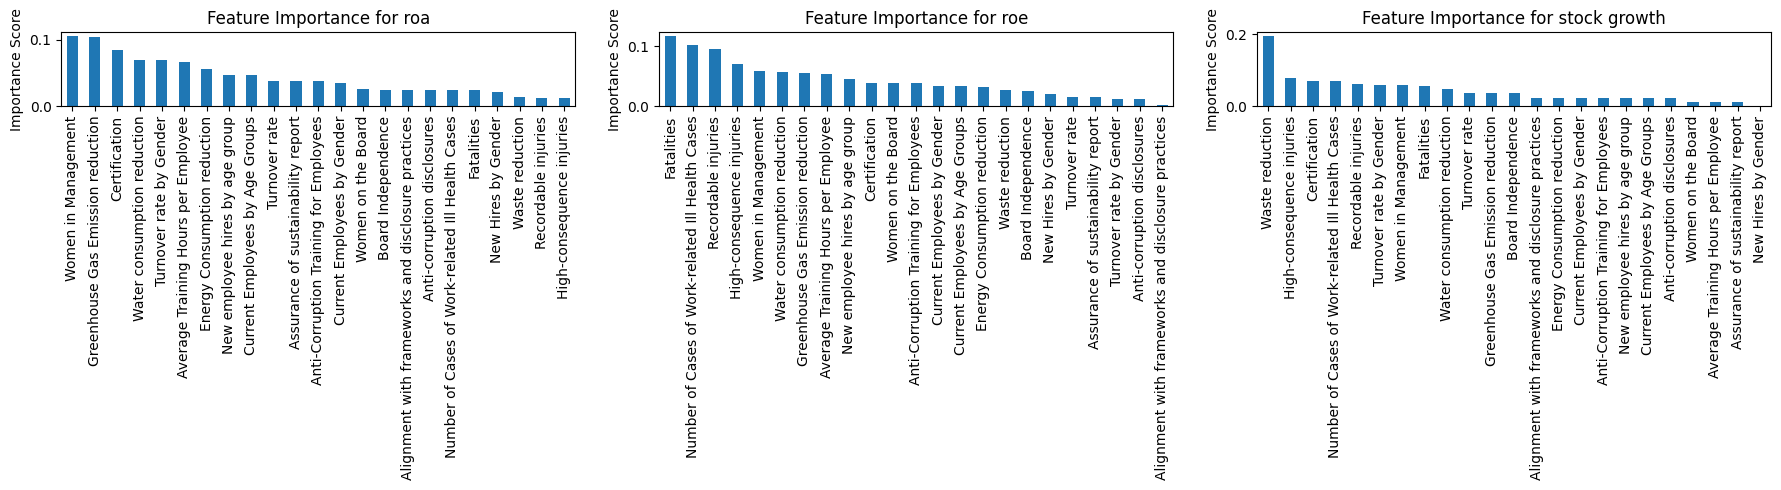

In [62]:
# Convert feature importance to DataFrame for visualization
importance_df = pd.DataFrame(feature_importance, index=X.columns)

# Plot feature importance for each target variable
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, target in enumerate(y.columns):
    importance_df[target].sort_values(ascending=False).plot(kind="bar", ax=axes[idx])
    axes[idx].set_title(f"Feature Importance for {target}")
    axes[idx].set_ylabel("Importance Score")

plt.tight_layout()
plt.show()

### Recursive Feature Elimination
with linear regression approximation (since VARMAX doesn't output feature importance)

Selects features that best **predict** each variable

In [6]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Define features and targets
features = esg_financial.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'date', 'beginning_price', 'ending_price'])
targets = ['roa', 'roe', 'stock growth']

top_features_rfe = {}

for target in targets:
    X = features
    y = esg_financial[target]

    # Fit an approximate linear model
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
    rfe.fit(X, y)

    # Get selected feature names
    selected_features = np.array(features.columns)[rfe.support_]
    top_features_rfe[target] = selected_features.tolist()

print("Top 5 features per target variable using RFE:")
print(top_features_rfe)


Top 5 features per target variable using RFE:
{'roa': ['Energy Consumption reduction', 'New employee hires by age group', 'Women on the Board', 'Anti-Corruption Training for Employees', 'Certification'], 'roe': ['Waste reduction', 'New employee hires by age group', 'Turnover rate', 'Board Independence', 'Women on the Board'], 'stock growth': ['Greenhouse Gas Emission reduction', 'Turnover rate by Gender', 'Women on the Board', 'Anti-corruption disclosures', 'Anti-Corruption Training for Employees']}


In [7]:
from collections import Counter

# Combine the selected features from all targets into one list
all_selected_features = top_features_rfe['roa'] + top_features_rfe['roe'] + top_features_rfe['stock growth']

# Count the frequency of each feature
feature_counts = Counter(all_selected_features)

# Sort features by frequency and select the top 5
top_5_features = [feature for feature, count in feature_counts.most_common(5)]
print("Top 5 Features Across All Targets:", top_5_features)


Top 5 Features Across All Targets: ['Women on the Board', 'New employee hires by age group', 'Anti-Corruption Training for Employees', 'Energy Consumption reduction', 'Certification']


### Some Experimental Nonsense with Lasso that doesn't even work

In [68]:
from sklearn.preprocessing import StandardScaler

# Define features and targets
features = esg_financial.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'date', 'beginning_price', 'ending_price'])
targets = ['roa', 'roe', 'stock growth']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [70]:
from sklearn.linear_model import LassoCV

top_features_lasso = {}

for target in targets:
    X = features_scaled
    y = esg_financial[target]

    # Initialize LassoCV, which automatically finds the best alpha via cross-validation
    lasso = LassoCV(cv=5)  # You can change cv to the number of folds you prefer
    lasso.fit(X, y)

    # Get the features that have non-zero coefficients
    selected_features = np.array(features.columns)[lasso.coef_ != 0]
    top_features_lasso[target] = selected_features.tolist()

print(top_features_lasso)


C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.807e-05, tolerance: 1.292e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.720e-05, tolerance: 1.292e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

{'roa': [], 'roe': [], 'stock growth': ['Waste reduction', 'Women in Management', 'Anti-Corruption Training for Employees']}


### Elasticity Analysis
How Much Does a 1% ESG Change Affect Financials?   
High elasticity means small ESG change leads to a big financial impact

For stock growth only

In [80]:
import statsmodels.api as sm

# Define target variable and features
X = esg_financial.drop(columns=['company', 'year', 'date', 'roa', 'roe', 'beginning_price', 'ending_price', 'stock growth'])  # ESG metrics
y = esg_financial['stock growth']

# Log transformation to get % changes (elasticity)
X_log = np.log(X + 1)  # Add 1 to avoid log(0)
y_log = np.log(y + 1)

# Fit linear regression
X_log = sm.add_constant(X_log)
model = sm.OLS(y_log, X_log).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           stock growth   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 23 Mar 2025   Prob (F-statistic):                nan
Time:                        01:51:52   Log-Likelihood:                 488.70
No. Observations:                  16   AIC:                            -945.4
Df Residuals:                       0   BIC:                            -933.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


# Linear Regression

In [96]:
# This is the right one

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Initialize an empty DataFrame to store all results
all_output_data = pd.DataFrame()

for company, company_data in esg_financial.groupby('company'):
    company_data = company_data.reset_index()  # Reset index to bring 'year' back as a column
    
    # Make sure 'year' is a column and not part of the index
    company_data['year'] = pd.to_datetime(company_data['year'], format='%Y').dt.year

    # Use 'year' and 'esg_metric' as features, and 'roa', 'roe', 'stock growth' as targets
    for esg_metric in top_5_features:
        endog = company_data[['roa', 'roe', 'stock growth']].dropna()  # Target variables
        exog = company_data[['year', esg_metric]].dropna()  # Features (time and ESG metric)
        
        # Ensure both target and exogenous variables have the same number of rows
        common_index = endog.index.intersection(exog.index)
        endog = endog.loc[common_index]
        exog = exog.loc[common_index]
        
        model = LinearRegression()
        model.fit(exog, endog)
        
        # Forecasting the next 5 years
        forecast_steps = 5
        latest_year = exog['year'].iloc[-1]
        latest_esg = exog[esg_metric].iloc[-1]
        
        # Prepare the forecast exogenous features (next 5 years)
        future_years = np.arange(latest_year + 1, latest_year + forecast_steps + 1).reshape(-1, 1)

        # **Consistent ESG Model**: Use the latest ESG value for all forecast years
        consistent_esg = np.full((forecast_steps, 1), latest_esg)

        # **Increasing ESG Model**: Increase the ESG value gradually by 0.1 each year, max value capped at 10
        increasing_esg = np.minimum(latest_esg + np.arange(forecast_steps) * 0.1, 10.0).reshape(-1, 1)

        # Combine future years with ESG values for both scenarios
        consistent_forecast_exog = np.hstack([future_years, consistent_esg])
        increasing_forecast_exog = np.hstack([future_years, increasing_esg])

        # Convert to DataFrames with appropriate column names
        consistent_exog_df = pd.DataFrame(consistent_forecast_exog, columns=['year', esg_metric])
        increasing_exog_df = pd.DataFrame(increasing_forecast_exog, columns=['year', esg_metric])

        # Predict the future values using the trained model for both consistent and increasing ESG
        consistent_forecast = model.predict(consistent_exog_df)
        increasing_forecast = model.predict(increasing_exog_df)
        
        # Create DataFrames for the forecast results
        consistent_forecast_df = pd.DataFrame(consistent_forecast, columns=endog.columns)
        increasing_forecast_df = pd.DataFrame(increasing_forecast, columns=endog.columns)

        # Add scenario details
        consistent_forecast_df['scenario'] = 'Consistent ESG'
        increasing_forecast_df['scenario'] = 'Increasing ESG'

        # Add ESG metric and company details
        consistent_forecast_df['esg metric'] = esg_metric
        increasing_forecast_df['esg metric'] = esg_metric
        consistent_forecast_df['metric score'] = latest_esg
        increasing_forecast_df['metric score'] = increasing_esg.flatten()
        consistent_forecast_df['company'] = company
        increasing_forecast_df['company'] = company
        
        # Forecasted years
        forecast_years = future_years
        consistent_forecast_df['year'] = forecast_years
        increasing_forecast_df['year'] = forecast_years
        
        # Add historical data for the company
        historical = company_data.copy()
        historical['scenario'] = 'Historical'
        historical['esg metric'] = esg_metric
        historical['metric score'] = company_data[esg_metric]
        historical = historical.reset_index()

        # Concatenate historical data and forecasted data
        output_data = pd.concat([
            historical[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],
            consistent_forecast_df[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],
            increasing_forecast_df[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']]
        ])
        
        # Append to the overall output DataFrame
        all_output_data = pd.concat([all_output_data, output_data])

# Save the output to a CSV file
all_output_data.to_csv('model_prediction_with_time_and_esg_scenarios.csv', index=False)

# Print the output data for verification
print(all_output_data)


            company  year       roa       roe  stock growth  \
0             Apple  2021  0.269742  1.500713      0.353931   
1             Apple  2022  0.282924  1.969589     -0.252294   
2             Apple  2023  0.275098  1.560760      0.341785   
3             Apple  2024  0.256825  1.645935      0.364679   
0             Apple  2025  0.244213  1.509293      0.639497   
..              ...   ...       ...       ...           ...   
0   WiseTech Global  2025  0.129080  0.160924      0.160742   
1   WiseTech Global  2026  0.136111  0.169691      0.049422   
2   WiseTech Global  2027  0.143141  0.178457     -0.061899   
3   WiseTech Global  2028  0.150171  0.187224     -0.173219   
4   WiseTech Global  2029  0.157201  0.195991     -0.284540   

            esg metric  metric score        scenario  
0   Women on the Board      6.257024      Historical  
1   Women on the Board      6.457397      Historical  
2   Women on the Board      6.538477      Historical  
3   Women on the Board 

In [97]:
# Filter data for Apple
apple_data = all_output_data[all_output_data['company'] == 'Apple']

# Select relevant columns (historical values + ESG metric)
historical_data = apple_data[apple_data['scenario'] == 'Historical']
consistent_esg_data = apple_data[apple_data['scenario'] == 'Consistent ESG']
improved_esg_data = apple_data[apple_data['scenario'] == 'Improved ESG']

# Assume 'Women on the Board' is one of the ESG metrics
esg_metric = 'Women on the Board'  # Update this if needed
historical_esg = historical_data[historical_data['esg metric'] == esg_metric]
consistent_esg = consistent_esg_data[consistent_esg_data['esg metric'] == esg_metric]
improved_esg = improved_esg_data[improved_esg_data['esg metric'] == esg_metric]

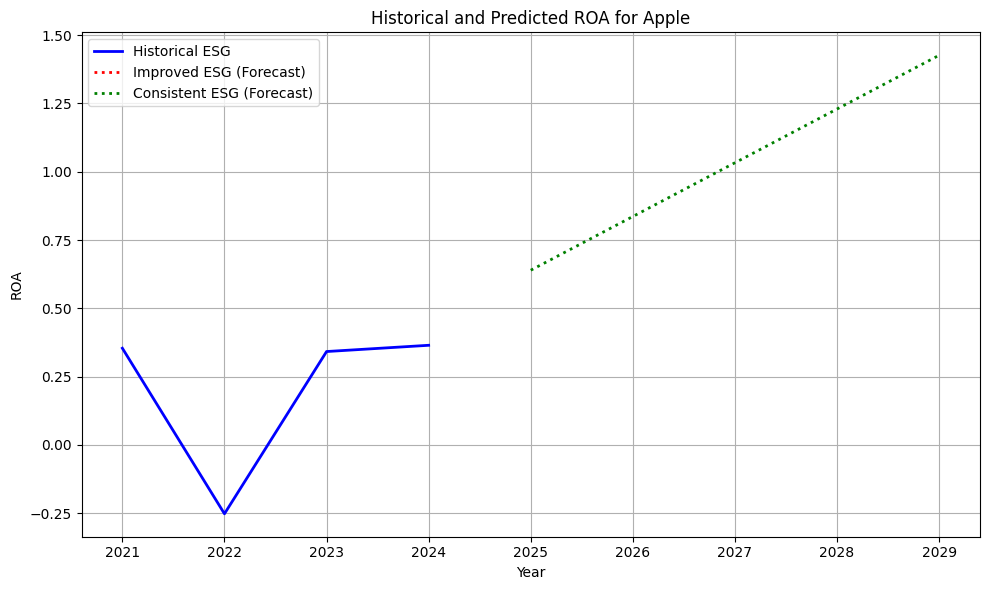

In [98]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(historical_esg['year'], historical_esg['stock growth'], label='Historical ESG', color='blue', linewidth=2)

# Plot improved ESG forecast (dotted red line)
plt.plot(improved_esg['year'], improved_esg['stock growth'], label='Improved ESG (Forecast)', color='red', linestyle='dotted', linewidth=2)

# Plot consistent ESG forecast (dotted green line)
plt.plot(consistent_esg['year'], consistent_esg['stock growth'], label='Consistent ESG (Forecast)', color='green', linestyle='dotted', linewidth=2)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ROA')
plt.title('Historical and Predicted ROA for Apple')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
forecast_steps = 5

# Forecast with original ESG scores
latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
forecast_consistent = results.forecast(steps=forecast_steps, exog=consistent_esg)

# Forecast with improved ESG scores
improved_esg = np.array([8.7, 8.8, 8.9, 9.0, 9.1]).reshape(-1, 1)  # Higher ESG scores
forecast_improved = results.forecast(steps=forecast_steps, exog=improved_esg)

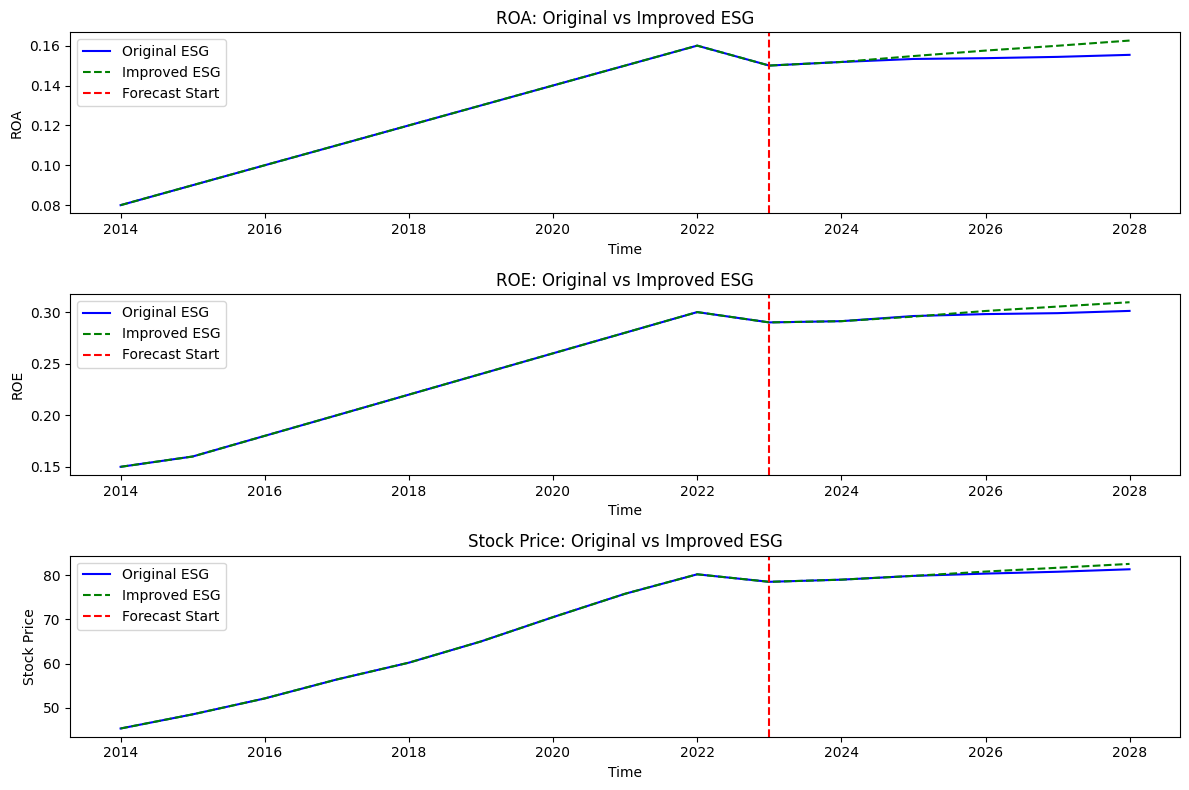

In [34]:
# Combine historical and forecasted data
historical = endog
combined_consistent = pd.concat([historical, forecast_consistent])
combined_improved = pd.concat([historical, forecast_improved])

# Plot the results
plt.figure(figsize=(12, 8))

# Plot ROA
plt.subplot(3, 1, 1)
plt.plot(combined_consistent.index, combined_consistent['ROA'], label='Original ESG', color='blue')
plt.plot(combined_improved.index, combined_improved['ROA'], label='Improved ESG', color='green', linestyle='--')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ROA: Original vs Improved ESG')
plt.xlabel('Time')
plt.ylabel('ROA')
plt.legend()

# Plot ROE
plt.subplot(3, 1, 2)
plt.plot(combined_consistent.index, combined_consistent['ROE'], label='Original ESG', color='blue')
plt.plot(combined_improved.index, combined_improved['ROE'], label='Improved ESG', color='green', linestyle='--')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('ROE: Original vs Improved ESG')
plt.xlabel('Time')
plt.ylabel('ROE')
plt.legend()

# Plot Stock Price
plt.subplot(3, 1, 3)
plt.plot(combined_consistent.index, combined_consistent['Stock_Price'], label='Original ESG', color='blue')
plt.plot(combined_improved.index, combined_improved['Stock_Price'], label='Improved ESG', color='green', linestyle='--')
plt.axvline(x=historical.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.title('Stock Price: Original vs Improved ESG')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:

# Add a 'Scenario' column to distinguish between constant and improved ESG
forecast_consistent['Scenario'] = 'Consistent ESG'
forecast_improved['Scenario'] = 'Improved ESG'

# Add ESG ratings used for prediction
forecast_consistent['ESG_Rating'] = consistent_esg.flatten()  # ESG ratings for consistent scenario
forecast_consistent = forecast_consistent.reset_index()
forecast_consistent = forecast_consistent.rename(columns={'index': 'Year'})
forecast_improved['ESG_Rating'] = improved_esg.flatten()  # ESG ratings for improved scenario
forecast_improved = forecast_improved.reset_index()
forecast_improved = forecast_improved.rename(columns={'index': 'Year'})

# Combine historical and forecasted data
historical = company_data.copy()
historical['Scenario'] = 'Historical'  # Label historical data
historical = historical.reset_index()

# Combine all data into a single DataFrame
output_data = pd.concat([
    historical[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Historical data
    forecast_consistent[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Consistent ESG forecast
    forecast_improved[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']]  # Improved ESG forecast
])

# Save the output to a CSV file
output_data.to_csv('current_and_predicted_metrics.csv', index=False)

# Print the output data for verification
print(output_data)

        Year       ROA       ROE  Stock_Price  ESG_Rating        Scenario
0 2014-01-01  0.080000  0.150000    45.300000         7.2      Historical
1 2015-01-01  0.090000  0.160000    48.500000         7.5      Historical
2 2016-01-01  0.100000  0.180000    52.100000         7.8      Historical
3 2017-01-01  0.110000  0.200000    56.400000         8.1      Historical
4 2018-01-01  0.120000  0.220000    60.200000         8.4      Historical
5 2019-01-01  0.130000  0.240000    65.000000         8.7      Historical
6 2020-01-01  0.140000  0.260000    70.500000         8.9      Historical
7 2021-01-01  0.150000  0.280000    75.800000         9.0      Historical
8 2022-01-01  0.160000  0.300000    80.200000         9.1      Historical
9 2023-01-01  0.150000  0.290000    78.500000         8.7      Historical
0 2024-01-01  0.151797  0.291198    78.986008         8.7  Consistent ESG
1 2025-01-01  0.153319  0.296193    79.847654         8.7  Consistent ESG
2 2026-01-01  0.153707  0.298050    80

In [21]:
esg_financial.isna().any(axis=None)

np.False_

In [32]:
for company, company_data in esg_financial.groupby('company'):
    company_data.set_index("year", inplace=True)
    company_data.index = pd.to_datetime(company_data.index, format='%Y')
    endog = company_data[['roa', 'roe', 'stock growth']]
    print(endog)

                 roa       roe  stock growth
year                                        
2021-01-01  0.269742  1.500713      0.353931
2022-01-01  0.282924  1.969589     -0.252294
2023-01-01  0.275098  1.560760      0.341785
2024-01-01  0.256825  1.645935      0.364679
                 roa       roe  stock growth
year                                        
2020-01-01  0.043591  0.156808      0.261334
2021-01-01  0.048142  0.136648      0.712890
2022-01-01  0.060717  0.159042     -0.243975
2023-01-01  0.067328  0.159078      0.129591
                 roa       roe  stock growth
year                                        
2021-01-01 -0.008713 -0.019924      0.733431
2022-01-01 -0.016693 -0.035562     -0.496954
2023-01-01  0.012339  0.023980      0.622510
2024-01-01  0.031761  0.067694      0.148264
                 roa       roe  stock growth
year                                        
2021-01-01  0.077220  0.097740      0.664207
2022-01-01  0.117042  0.148038      0.392016
2023-01-01

In [36]:
metrics = esg_financial.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'date', 'beginning_price', 'ending_price']).columns.values
for company, company_data in esg_financial.groupby('company'):
    company_data = company_data.reset_index()  # Reset index to bring 'year' back as a column
    
    for esg_metric in metrics:
        # Set the year as the index
        if "year" in company_data.columns:
            company_data.set_index("year", inplace=True)
        
        # Ensure the index is in a supported format
        # Convert the 'Year' column to a DatetimeIndex with yearly frequency
        company_data.index = pd.to_datetime(company_data.index, format='%Y')
        
        # Prepare endogenous and exogenous variables
        endog = company_data[['roa', 'roe', 'stock growth']]
        exog = company_data[[esg_metric]]
        print(company_data.isna().sum())  # Check missing values
        print(company_data.isin([np.inf, -np.inf]).sum())  # Check for infinite values


index                                                 0
company                                               0
Greenhouse Gas Emission reduction                     0
Energy Consumption reduction                          0
Water consumption reduction                           0
Waste reduction                                       0
Current Employees by Gender                           0
Turnover rate by Gender                               0
New Hires by Gender                                   0
Current Employees by Age Groups                       0
New employee hires by age group                       0
Turnover rate                                         0
Average Training Hours per Employee                   0
Fatalities                                            0
High-consequence injuries                             0
Recordable injuries                                   0
Number of Cases of Work-related Ill Health Cases      0
Board Independence                              

In [38]:
# Initialize an empty DataFrame to store all results
all_output_data = pd.DataFrame()

# Current Employees by Age Groups
for company, company_data in esg_financial.groupby('company'):
        company_data.set_index("year", inplace=True)
        
        # Ensure the index is in a supported format
        # Convert the 'Year' column to a DatetimeIndex with yearly frequency
        company_data.index = pd.to_datetime(company_data.index, format='%Y')
        
        # Prepare endogenous and exogenous variables
        endog = company_data[['roa', 'roe', 'stock growth']]
        exog = company_data[['Current Employees by Age Groups']]

        # Fit the VARMAX model
        model = VARMAX(endog, exog=exog, order=(1, 0))  # Adjust order as needed
        results = model.fit(maxiter=1000, disp=False)
    
        forecast_steps = 5
    
        # Forecast with original ESG scores
        latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
        consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
        forecast_consistent = results.forecast(steps=forecast_steps, exog=consistent_esg)
    
        # Forecast with improved ESG scores
        # Generate improved ESG scores dynamically (incrementing by 0.1 until 10)
        improved_esg = np.minimum(latest_esg + np.arange(forecast_steps) * 0.1, 10.0).reshape(-1, 1)
        forecast_improved = results.forecast(steps=forecast_steps, exog=improved_esg)
            
        # Add a 'Scenario' column to distinguish between constant and improved ESG
        forecast_consistent['scenario'] = 'Consistent ESG'
        forecast_improved['scenario'] = 'Improved ESG'
        
        # Add ESG metric used for prediction
        forecast_consistent['esg metric'] = np.full(forecast_steps, esg_metric).reshape(-1,1)  # ESG metric for consistent scenario
        forecast_consistent['metric score'] = consistent_esg.flatten()  # ESG metric score for consistent scenario
        forecast_improved['esg metric'] = np.full(forecast_steps, esg_metric).reshape(-1,1)  # ESG metric for improved scenario
        forecast_improved['metric score'] = improved_esg.flatten()  # ESG metric score for improved scenario
    
        # Standardize the Year index to column
        forecast_consistent = forecast_consistent.reset_index()
        forecast_consistent = forecast_consistent.rename(columns={'index': 'Year'})
        forecast_improved = forecast_improved.reset_index()
        forecast_improved = forecast_improved.rename(columns={'index': 'Year'})
    
        # Add company information
        forecast_consistent['company'] = company
        forecast_improved['company'] = company
        
        # Combine historical and forecasted data
        historical = company_data.copy()
        historical['Scenario'] = 'Historical'  # Label historical data
        historical = historical.reset_index()
        
        # Combine all data into a single DataFrame
        output_data = pd.concat([
            historical[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],  # Historical data
            forecast_consistent[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],  # Consistent ESG forecast
            forecast_improved[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']]  # Improved ESG forecast
        ])
    
        # Append to the combined DataFrame
        all_output_data = pd.concat([all_output_data, output_data])

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ValueError: array must not contain infs or NaNs

In [37]:
# Initialize an empty DataFrame to store all results
all_output_data = pd.DataFrame()

# Get ESG core metric column names
metrics = esg_financial.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'date', 'beginning_price', 'ending_price']).columns.values
for company, company_data in esg_financial.groupby('company'):
    company_data = company_data.reset_index()  # Reset index to bring 'year' back as a column
    
    for esg_metric in metrics:
        # Set the year as the index
        if "year" in company_data.columns:
            company_data.set_index("year", inplace=True)
        
        # Ensure the index is in a supported format
        # Convert the 'Year' column to a DatetimeIndex with yearly frequency
        company_data.index = pd.to_datetime(company_data.index, format='%Y')
        
        # Prepare endogenous and exogenous variables
        #endog = company_data[['roa', 'roe', 'stock growth']]
        #exog = company_data[[esg_metric]]

        endog = company_data[['roa', 'roe', 'stock growth']].dropna()
        exog = company_data[[esg_metric]].dropna()
        
        # Make sure they have the same number of rows
        common_index = endog.index.intersection(exog.index)
        endog = endog.loc[common_index]
        exog = exog.loc[common_index]

        # Fit the VARMAX model
        model = VARMAX(endog, exog=exog, order=(1, 0))  # Adjust order as needed
        results = model.fit(maxiter=1000, disp=False)
    
        forecast_steps = 5
    
        # Forecast with original ESG scores
        latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
        consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
        forecast_consistent = results.forecast(steps=forecast_steps, exog=consistent_esg)
    
        # Forecast with improved ESG scores
        # Generate improved ESG scores dynamically (incrementing by 0.1 until 10)
        improved_esg = np.minimum(latest_esg + np.arange(forecast_steps) * 0.1, 10.0).reshape(-1, 1)
        forecast_improved = results.forecast(steps=forecast_steps, exog=improved_esg)
    
        # Add a 'Scenario' column to distinguish between constant and improved ESG
        forecast_consistent['scenario'] = 'Consistent ESG'
        forecast_improved['scenario'] = 'Improved ESG'
        
        # Add ESG metric used for prediction
        forecast_consistent['esg metric'] = np.full(forecast_steps, esg_metric).reshape(-1,1)  # ESG metric for consistent scenario
        forecast_consistent['metric score'] = consistent_esg.flatten()  # ESG metric score for consistent scenario
        forecast_improved['esg metric'] = np.full(forecast_steps, esg_metric).reshape(-1,1)  # ESG metric for improved scenario
        forecast_improved['metric score'] = improved_esg.flatten()  # ESG metric score for improved scenario
    
        # Standardize the Year index to column
        forecast_consistent = forecast_consistent.reset_index()
        forecast_consistent = forecast_consistent.rename(columns={'index': 'Year'})
        forecast_improved = forecast_improved.reset_index()
        forecast_improved = forecast_improved.rename(columns={'index': 'Year'})
    
        # Add company information
        forecast_consistent['company'] = company
        forecast_improved['company'] = company
        
        # Combine historical and forecasted data
        historical = company_data.copy()
        historical['Scenario'] = 'Historical'  # Label historical data
        historical = historical.reset_index()
        
        # Combine all data into a single DataFrame
        output_data = pd.concat([
            historical[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],  # Historical data
            forecast_consistent[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],  # Consistent ESG forecast
            forecast_improved[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']]  # Improved ESG forecast
        ])
    
        # Append to the combined DataFrame
        all_output_data = pd.concat([all_output_data, output_data])

# Save the output to a CSV file
all_output_data.to_csv('model_prediction.csv', index=False)

# Print the output data for verification
print(all_output_data)

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ValueError: array must not contain infs or NaNs

In [40]:
# Pivot the data to have years as rows and variables as columns
# We'll focus on one company for simplicity (e.g. Apple)
company_data = esg_financial[esg_financial["company"] == "Apple"]
company_data = company_data[["year", "Greenhouse Gas Emission reduction", "roa", "roe", "stock growth"]]

# Set the year as the index
company_data.set_index("year", inplace=True)

# Ensure the index is in a supported format
# Convert the 'Year' column to a DatetimeIndex with yearly frequency
company_data.index = pd.to_datetime(company_data.index, format='%Y')

# Check for missing values
print(company_data.isnull().sum())

# Prepare endogenous and exogenous variables
endog = company_data[['roa', 'roe', 'stock growth']]
exog = company_data[['Greenhouse Gas Emission reduction']]

# Fit the VARMAX model
model = VARMAX(endog, exog=exog, order=(1, 0))  # Adjust order as needed
results = model.fit(maxiter=1000, disp=False)

forecast_steps = 5

# Forecast with original ESG scores
latest_esg = exog.iloc[-1].values[0]  # Latest ESG value (e.g., 8.7 for 2023)
consistent_esg = np.full(forecast_steps, latest_esg).reshape(-1, 1)  # Constant ESG array
forecast_consistent = results.forecast(steps=forecast_steps, exog=consistent_esg)

# Forecast with improved ESG scores
improved_esg = np.array([8.7, 8.8, 8.9, 9.0, 9.1]).reshape(-1, 1)  # Higher ESG scores
forecast_improved = results.forecast(steps=forecast_steps, exog=improved_esg)


# Add a 'Scenario' column to distinguish between constant and improved ESG
forecast_consistent['Scenario'] = 'Consistent ESG'
forecast_improved['Scenario'] = 'Improved ESG'

# Add ESG ratings used for prediction
forecast_consistent['ESG_Rating'] = consistent_esg.flatten()  # ESG ratings for consistent scenario
forecast_consistent = forecast_consistent.reset_index()
forecast_consistent = forecast_consistent.rename(columns={'index': 'Year'})
forecast_improved['ESG_Rating'] = improved_esg.flatten()  # ESG ratings for improved scenario
forecast_improved = forecast_improved.reset_index()
forecast_improved = forecast_improved.rename(columns={'index': 'Year'})

# Combine historical and forecasted data
historical = company_data.copy()
historical['Scenario'] = 'Historical'  # Label historical data
historical = historical.reset_index()

# Combine all data into a single DataFrame
output_data = pd.concat([
    historical[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Historical data
    forecast_consistent[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']],  # Consistent ESG forecast
    forecast_improved[['Year', 'ROA', 'ROE', 'Stock_Price', 'ESG_Rating', 'Scenario']]  # Improved ESG forecast
])

# Print the output data for verification
print(output_data)

Greenhouse Gas Emission reduction    0
roa                                  0
roe                                  0
stock growth                         0
dtype: int64


C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ValueError: array must not contain infs or NaNs